In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

#https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1       8.0       NaN     16.9     21.8         No      0.0   
1       1007.8       NaN       NaN     17.2     24.3         No      0.0   
2       1008.7       NaN       2.0     21.0     23.2         No      0.0   
3       1012.8       NaN       NaN     18.1     26.5         No      1.0   
4       1006.0       7.0       8.0     17.8     29.7         No      0.2   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 24 columns]

In [3]:
df.shape

(142193, 24)

In [4]:
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

“RainToday” and “RainTomorrow” are objects (Yes / No). I will convert them to binary (1/0) for our convenience.

In [5]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Next, we will check if the dataset is unbalanced or balanced. If the data set is unbalanced, we need to either downsample the majority or oversample the minority to balance it.



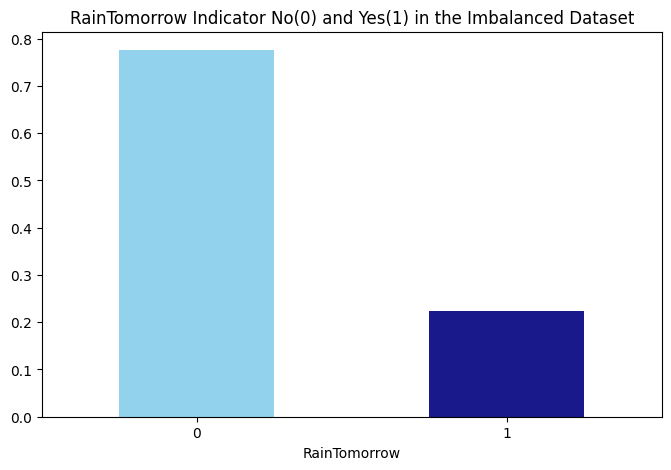

In [6]:
fig = plt.figure(figsize = (8,5),dpi=100)
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can observe that the presence of “0” and “1” is almost in the 78:22 ratio. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use here the oversampling of the minority class. Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

### Handling Class Imbalance

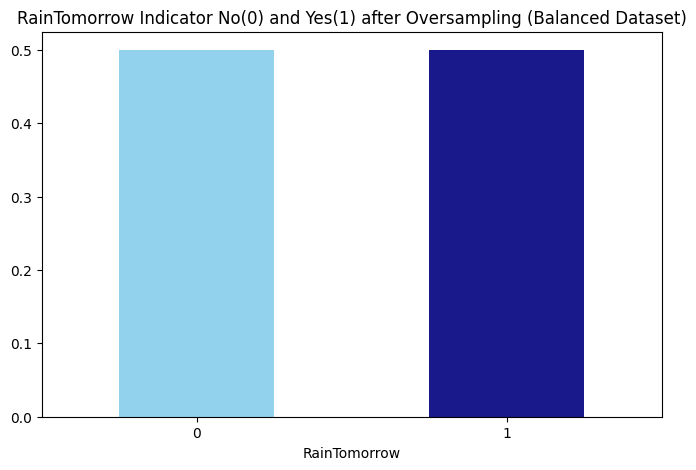

In [7]:
from sklearn.utils import resample

no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]

yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

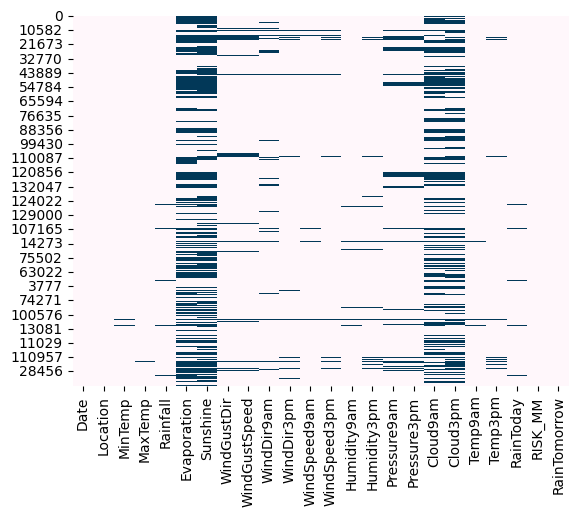

In [8]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

Obviously, “Evaporation”, “Sunshine”, “Cloud9am”, “Cloud3pm” are the features with a high missing percentage. So we will check the details of the missing data for these 4 features.

In [9]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

Total   Percent
Sunshine     104831  0.475140
Evaporation   95411  0.432444
Cloud3pm      85614  0.388040
Cloud9am      81339  0.368664

We observe that the 4 features have less than 50 per cent missing data. So instead of rejecting them completely, we’ll consider them in our model with proper imputation.



### Imputation and Transformation

In [10]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [11]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [12]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [13]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [14]:
MiceImputed.head()

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine  \
0   396         2     13.4     22.9       0.6     5.735438   7.364116   
1   397         2      7.4     25.1       0.0     5.639582  11.470601   
2   398         2     12.9     25.7       0.0     7.762987  12.281872   
3   399         2      9.2     28.0       0.0     5.977338  11.743982   
4   400         2     17.5     32.3       1.0     6.852950   5.756442   

   WindGustDir  WindGustSpeed  WindDir9am  ...  Humidity3pm  Pressure9am  \
0           13           44.0          13  ...         22.0       1007.7   
1           14           44.0           6  ...         25.0       1010.6   
2           15           46.0          13  ...         30.0       1007.6   
3            4           24.0           9  ...         16.0       1017.6   
4           13           41.0           1  ...         33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1  8.000000  4.868720     16.9     21.8        0.0      0.0   
1       1007.8  1.734671  2.639541     17.2     24.3        0.0      0.0   
2       1008.7  1.820254  2.000000     21.0     23.2        0.0      0.0   
3       1012.8  1.236006  2.133027     18.1     26.5        0.0      1.0   
4       1006.0  7.000000  8.000000     17.8     29.7        0.0      0.2   

   RainTomorrow  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 24 columns]

In [15]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [16]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

We are now going to check multicollinearity, that is to say if a character is strongly correlated with another.

<Axes: >

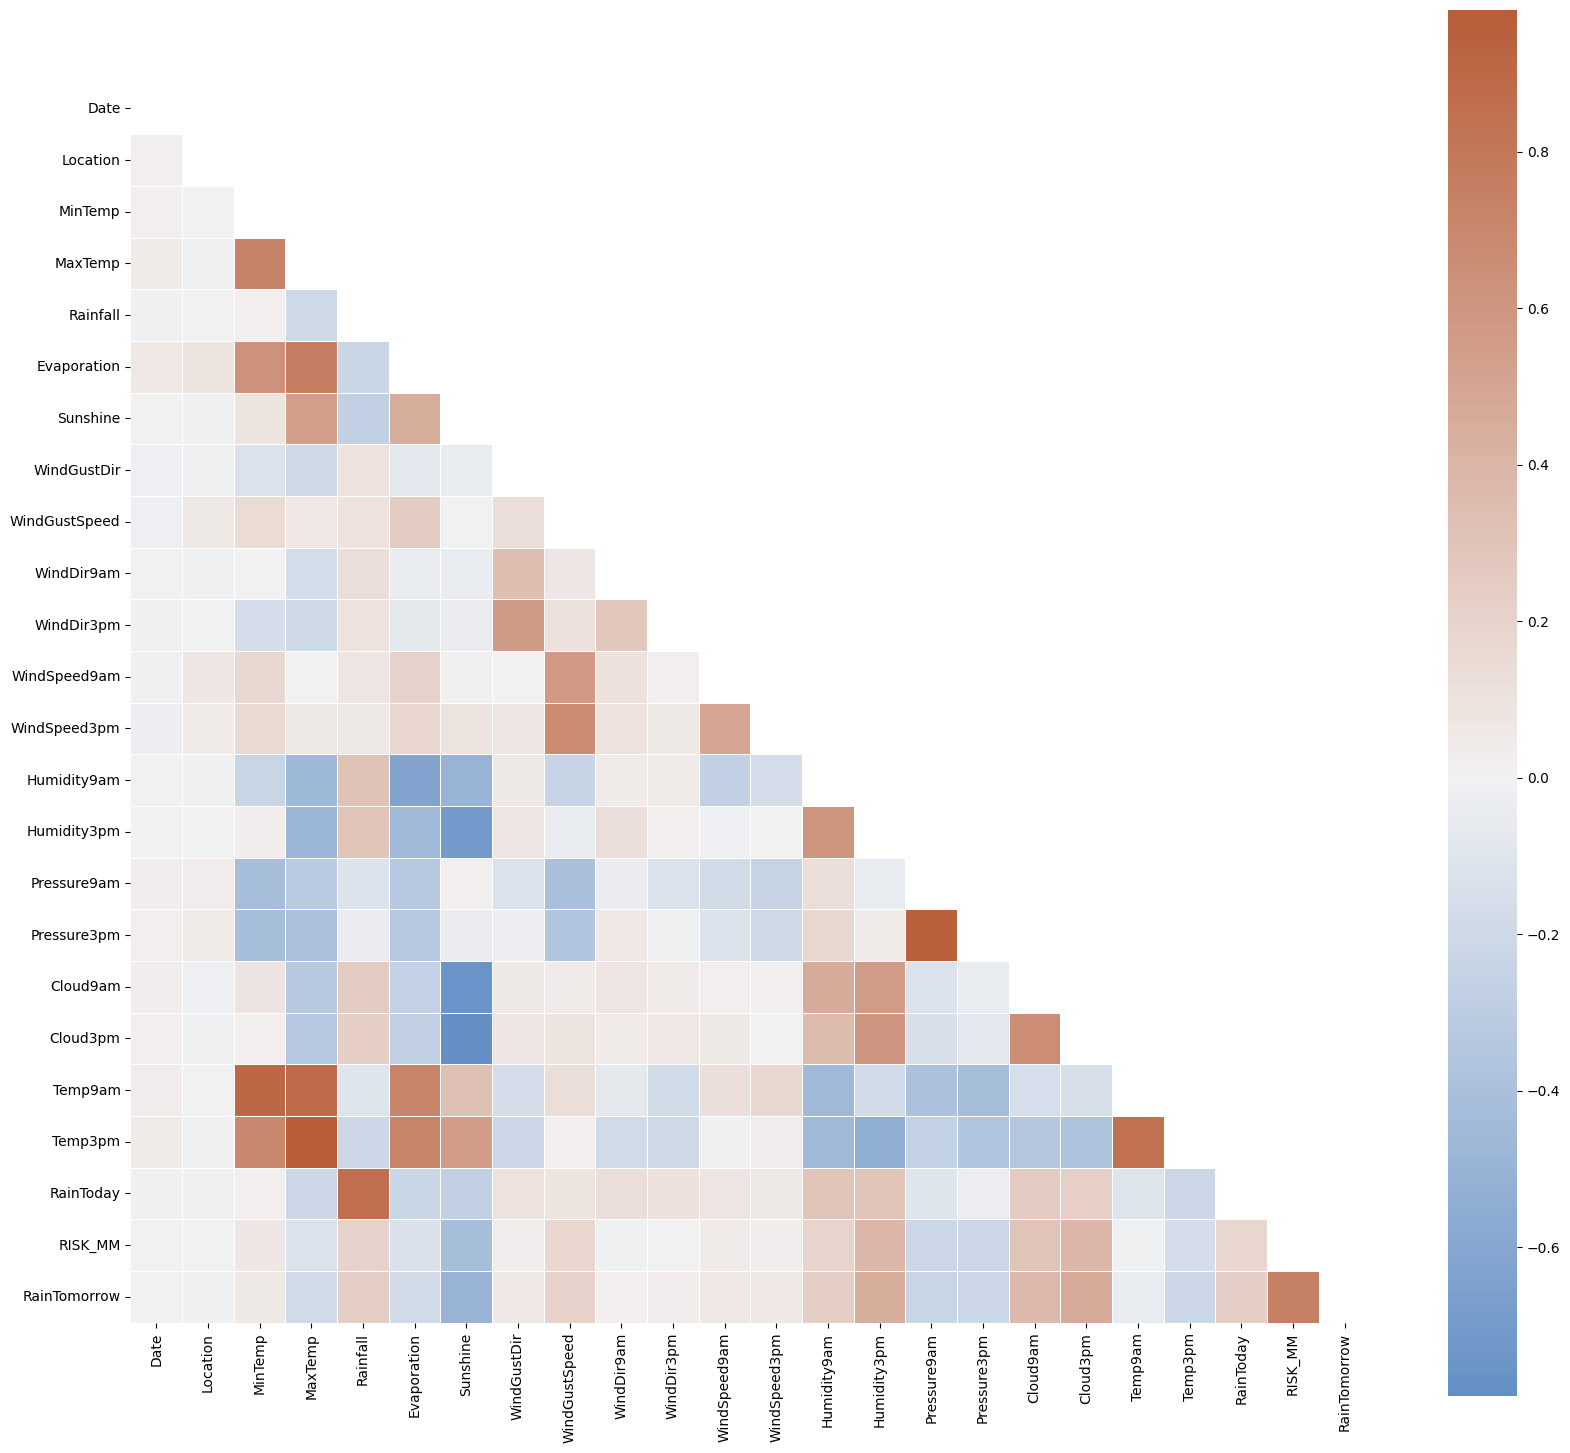

In [17]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

~The following feature pairs have a strong correlation with each other:


MaxTemp and MinTemp
Pressure9h and pressure3h
Temp9am and Temp3pm
Evaporation and MaxTemp
MaxTemp and Temp3pm But in no case is the correlation value equal to a perfect “1”. We are therefore not removing any functionality
However, we can delve deeper into the pairwise correlation between these highly correlated characteristics by examining the following pair diagram. Each of the paired plots shows very clearly distinct clusters of RainTomorrow’s “yes” and “no” clusters. There is very minimal overlap between them.

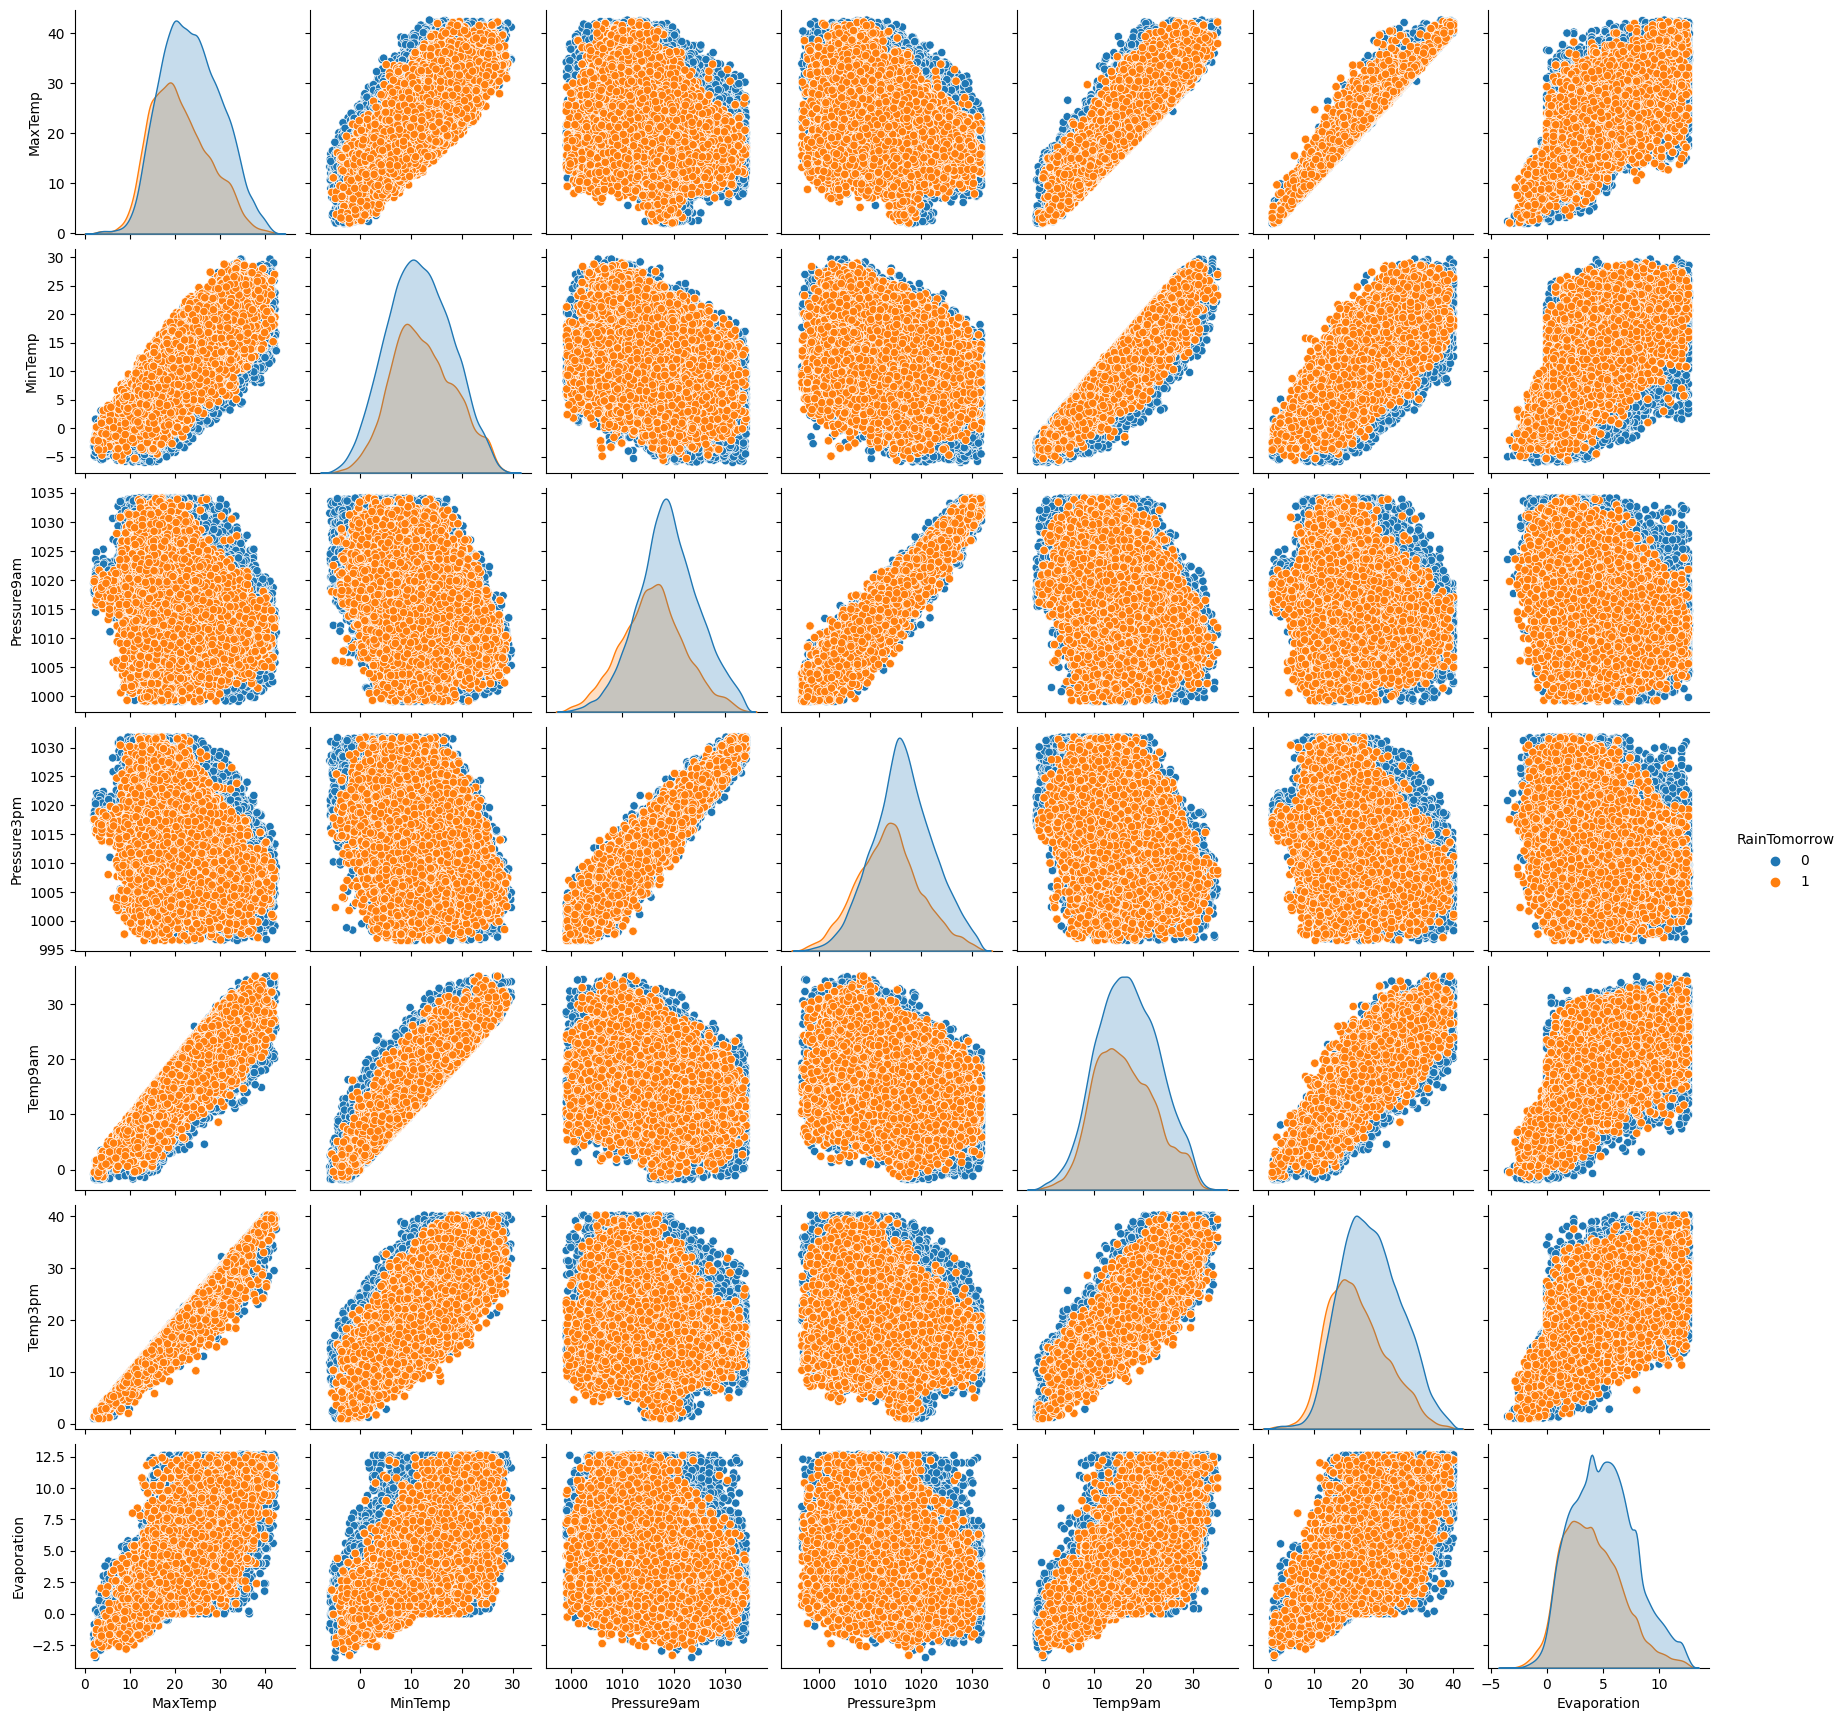

In [18]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

### Feature Selection for Rainfall Prediction

I will use both the filter method and the wrapper method for feature selection to train our rainfall prediction model.

Selecting features by filtering method (chi-square value): before doing this, we must first normalize our data. We use MinMaxScaler instead of StandardScaler in order to avoid negative values.



In [19]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [20]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)

SelectKBest(score_func=<function chi2 at 0x1770a0cc0>)

In [21]:
df0= pd.DataFrame(selector.scores_,columns=['Avg_Score'])

In [22]:
df1 = pd.DataFrame(X.columns)

In [23]:
All_features = pd.concat([df1,df0],axis=1)

In [24]:
All_features.nlargest(10,'Avg_Score')

0     Avg_Score
22      RISK_MM  32011.041411
6      Sunshine   3390.124830
18     Cloud3pm   3330.492832
14  Humidity3pm   2346.933591
21    RainToday   1778.077211
17     Cloud9am   1579.378115
13  Humidity9am    660.828020
15  Pressure9am    505.899713
16  Pressure3pm    424.841646
20      Temp3pm    424.062389

We can observe that “Sunshine”, “Humidity9am”, “Humidity3pm”, “Pressure9am”, “Pressure3pm” have higher importance compared to other features.

### Selection of features by wrapping method (random forest):

<Axes: >

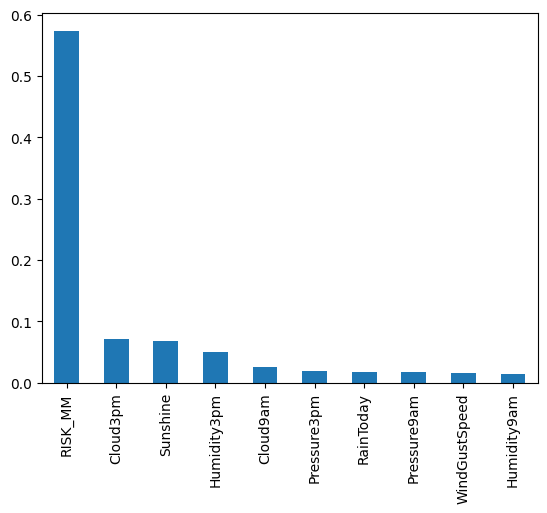

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
model = ExtraTreesClassifier()
model.fit(X,y)
model.feature_importances_
top_fe = pd.Series(model.feature_importances_,index = X.columns)
top_fe.nlargest(10).plot(kind='bar')

### Training Rainfall Prediction Model with Different Models


In [26]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [27]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='skyblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [34]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0
    
    # Format the numbers to display only two decimal places
    accuracy_formatted = "{:.2f}".format(accuracy)
    roc_auc_formatted = "{:.2f}".format(roc_auc)
    coh_kap_formatted = "{:.2f}".format(coh_kap)
    time_taken_formatted = "{:.2f}".format(time_taken)
    
    print("Accuracy = {}".format(accuracy_formatted))
    print("ROC Area under Curve = {}".format(roc_auc_formatted))
    print("Cohen's Kappa = {}".format(coh_kap_formatted))
    print("Time taken = {}".format(time_taken_formatted))
    print(classification_report(y_test, y_pred, digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    return model, accuracy, roc_auc, coh_kap, time_taken


Accuracy = 0.79
ROC Area under Curve = 0.77
Cohen's Kappa = 0.55
Time taken = 1.81
              precision    recall  f1-score   support

           0    0.80825   0.85945   0.83306     23948
           1    0.75516   0.68012   0.71568     15265

    accuracy                        0.78964     39213
   macro avg    0.78171   0.76978   0.77437     39213
weighted avg    0.78758   0.78964   0.78737     39213



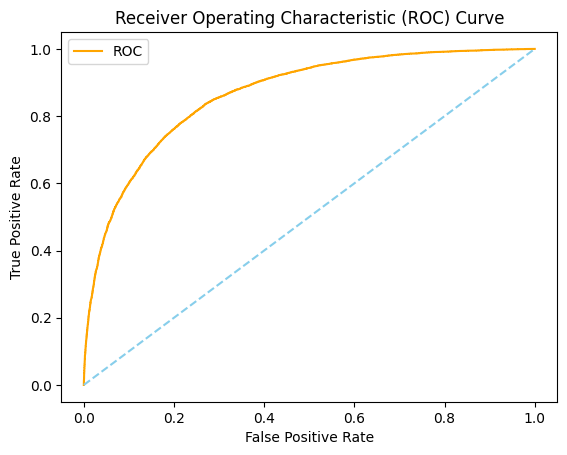

Accuracy = 0.86
ROC Area under Curve = 0.85
Cohen's Kappa = 0.70
Time taken = 0.48
              precision    recall  f1-score   support

           0    0.89237   0.87181   0.88197     23948
           1    0.80591   0.83505   0.82022     15265

    accuracy                        0.85750     39213
   macro avg    0.84914   0.85343   0.85109     39213
weighted avg    0.85871   0.85750   0.85793     39213



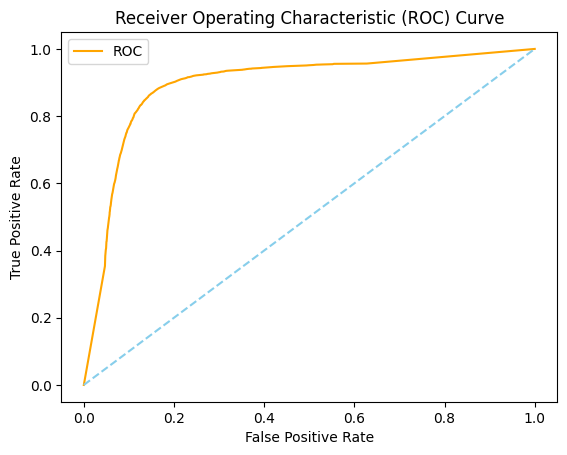

Accuracy = 0.88
ROC Area under Curve = 0.88
Cohen's Kappa = 0.76
Time taken = 394.08
              precision    recall  f1-score   support

           0    0.90617   0.90450   0.90533     23948
           1    0.85061   0.85306   0.85183     15265

    accuracy                        0.88448     39213
   macro avg    0.87839   0.87878   0.87858     39213
weighted avg    0.88454   0.88448   0.88451     39213



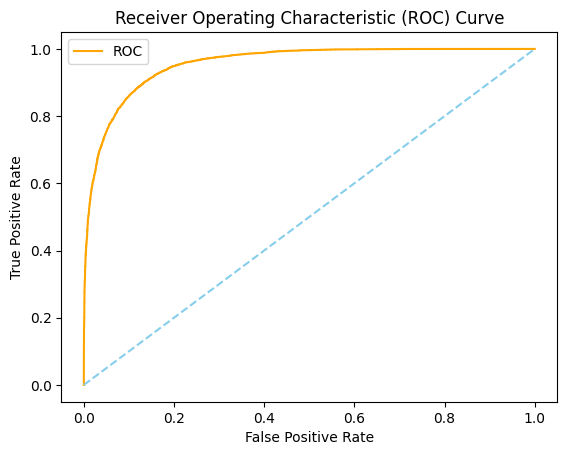

Accuracy = 0.93
ROC Area under Curve = 0.93
Cohen's Kappa = 0.85
Time taken = 27.37
              precision    recall  f1-score   support

           0    0.94766   0.93298   0.94026     23948
           1    0.89735   0.91916   0.90813     15265

    accuracy                        0.92760     39213
   macro avg    0.92251   0.92607   0.92419     39213
weighted avg    0.92808   0.92760   0.92775     39213



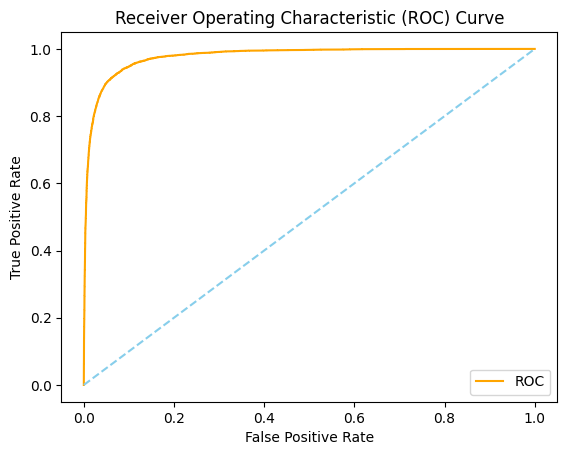

[LightGBM] [Info] Number of positive: 45912, number of negative: 71727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 117639, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390279 -> initscore=-0.446141
[LightGBM] [Info] Start training from score -0.446141
Accuracy = 0.87
ROC Area under Curve = 0.86
Cohen's Kappa = 0.72
Time taken = 1.45
              precision    recall  f1-score   support

           0    0.88961   0.89577   0.89268     23948
           1    0.83469   0.82561   0.83013     15265

    accuracy                        0.86846     39213
   macro avg    0.86215   0.86069   0.86140     39213
weighted avg    0.86823   0.86846   0.86833     39213



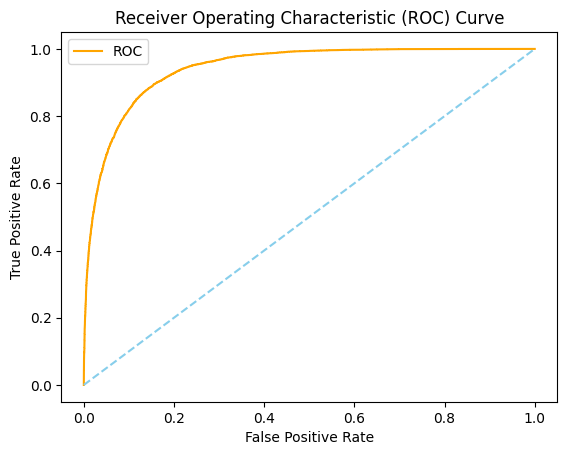

Accuracy = 0.94
ROC Area under Curve = 0.94
Cohen's Kappa = 0.88
Time taken = 116.61
              precision    recall  f1-score   support

           0    0.97256   0.93106   0.95136     23948
           1    0.89863   0.95879   0.92774     15265

    accuracy                        0.94186     39213
   macro avg    0.93560   0.94493   0.93955     39213
weighted avg    0.94378   0.94186   0.94216     39213



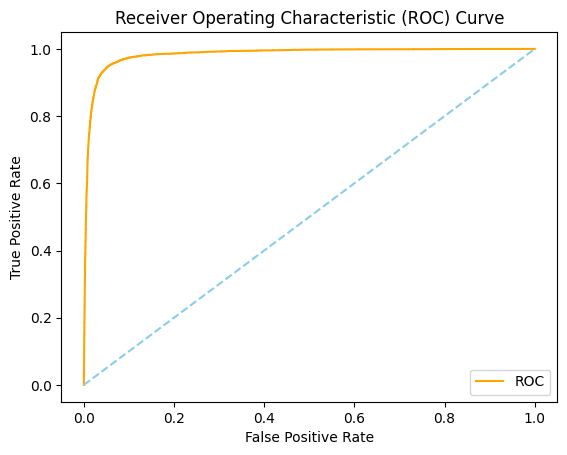

Accuracy = 0.96
ROC Area under Curve = 0.96
Cohen's Kappa = 0.91
Time taken = 100.06
              precision    recall  f1-score   support

           0    0.97275   0.95553   0.96406     23948
           1    0.93212   0.95801   0.94489     15265

    accuracy                        0.95649     39213
   macro avg    0.95243   0.95677   0.95447     39213
weighted avg    0.95693   0.95649   0.95660     39213



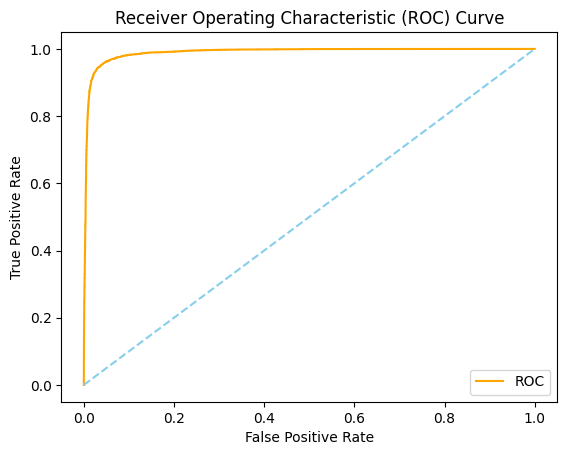

In [35]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

### Rainfall Prediction Model Comparison

Now we need to decide which model performed best based on Precision Score, ROC_AUC, Cohen’s Kappa and Total Run Time. One point to mention here is: we could have considered F1-Score as a better metric for judging model performance instead of accuracy, but we have already converted the unbalanced dataset to a balanced one, so consider accuracy as a metric for deciding the best model is justified in this case.

For a better decision, we chose “Cohen’s Kappa” which is actually an ideal choice as a metric to decide on the best model in case of unbalanced datasets. Let’s check which model worked well on which front:

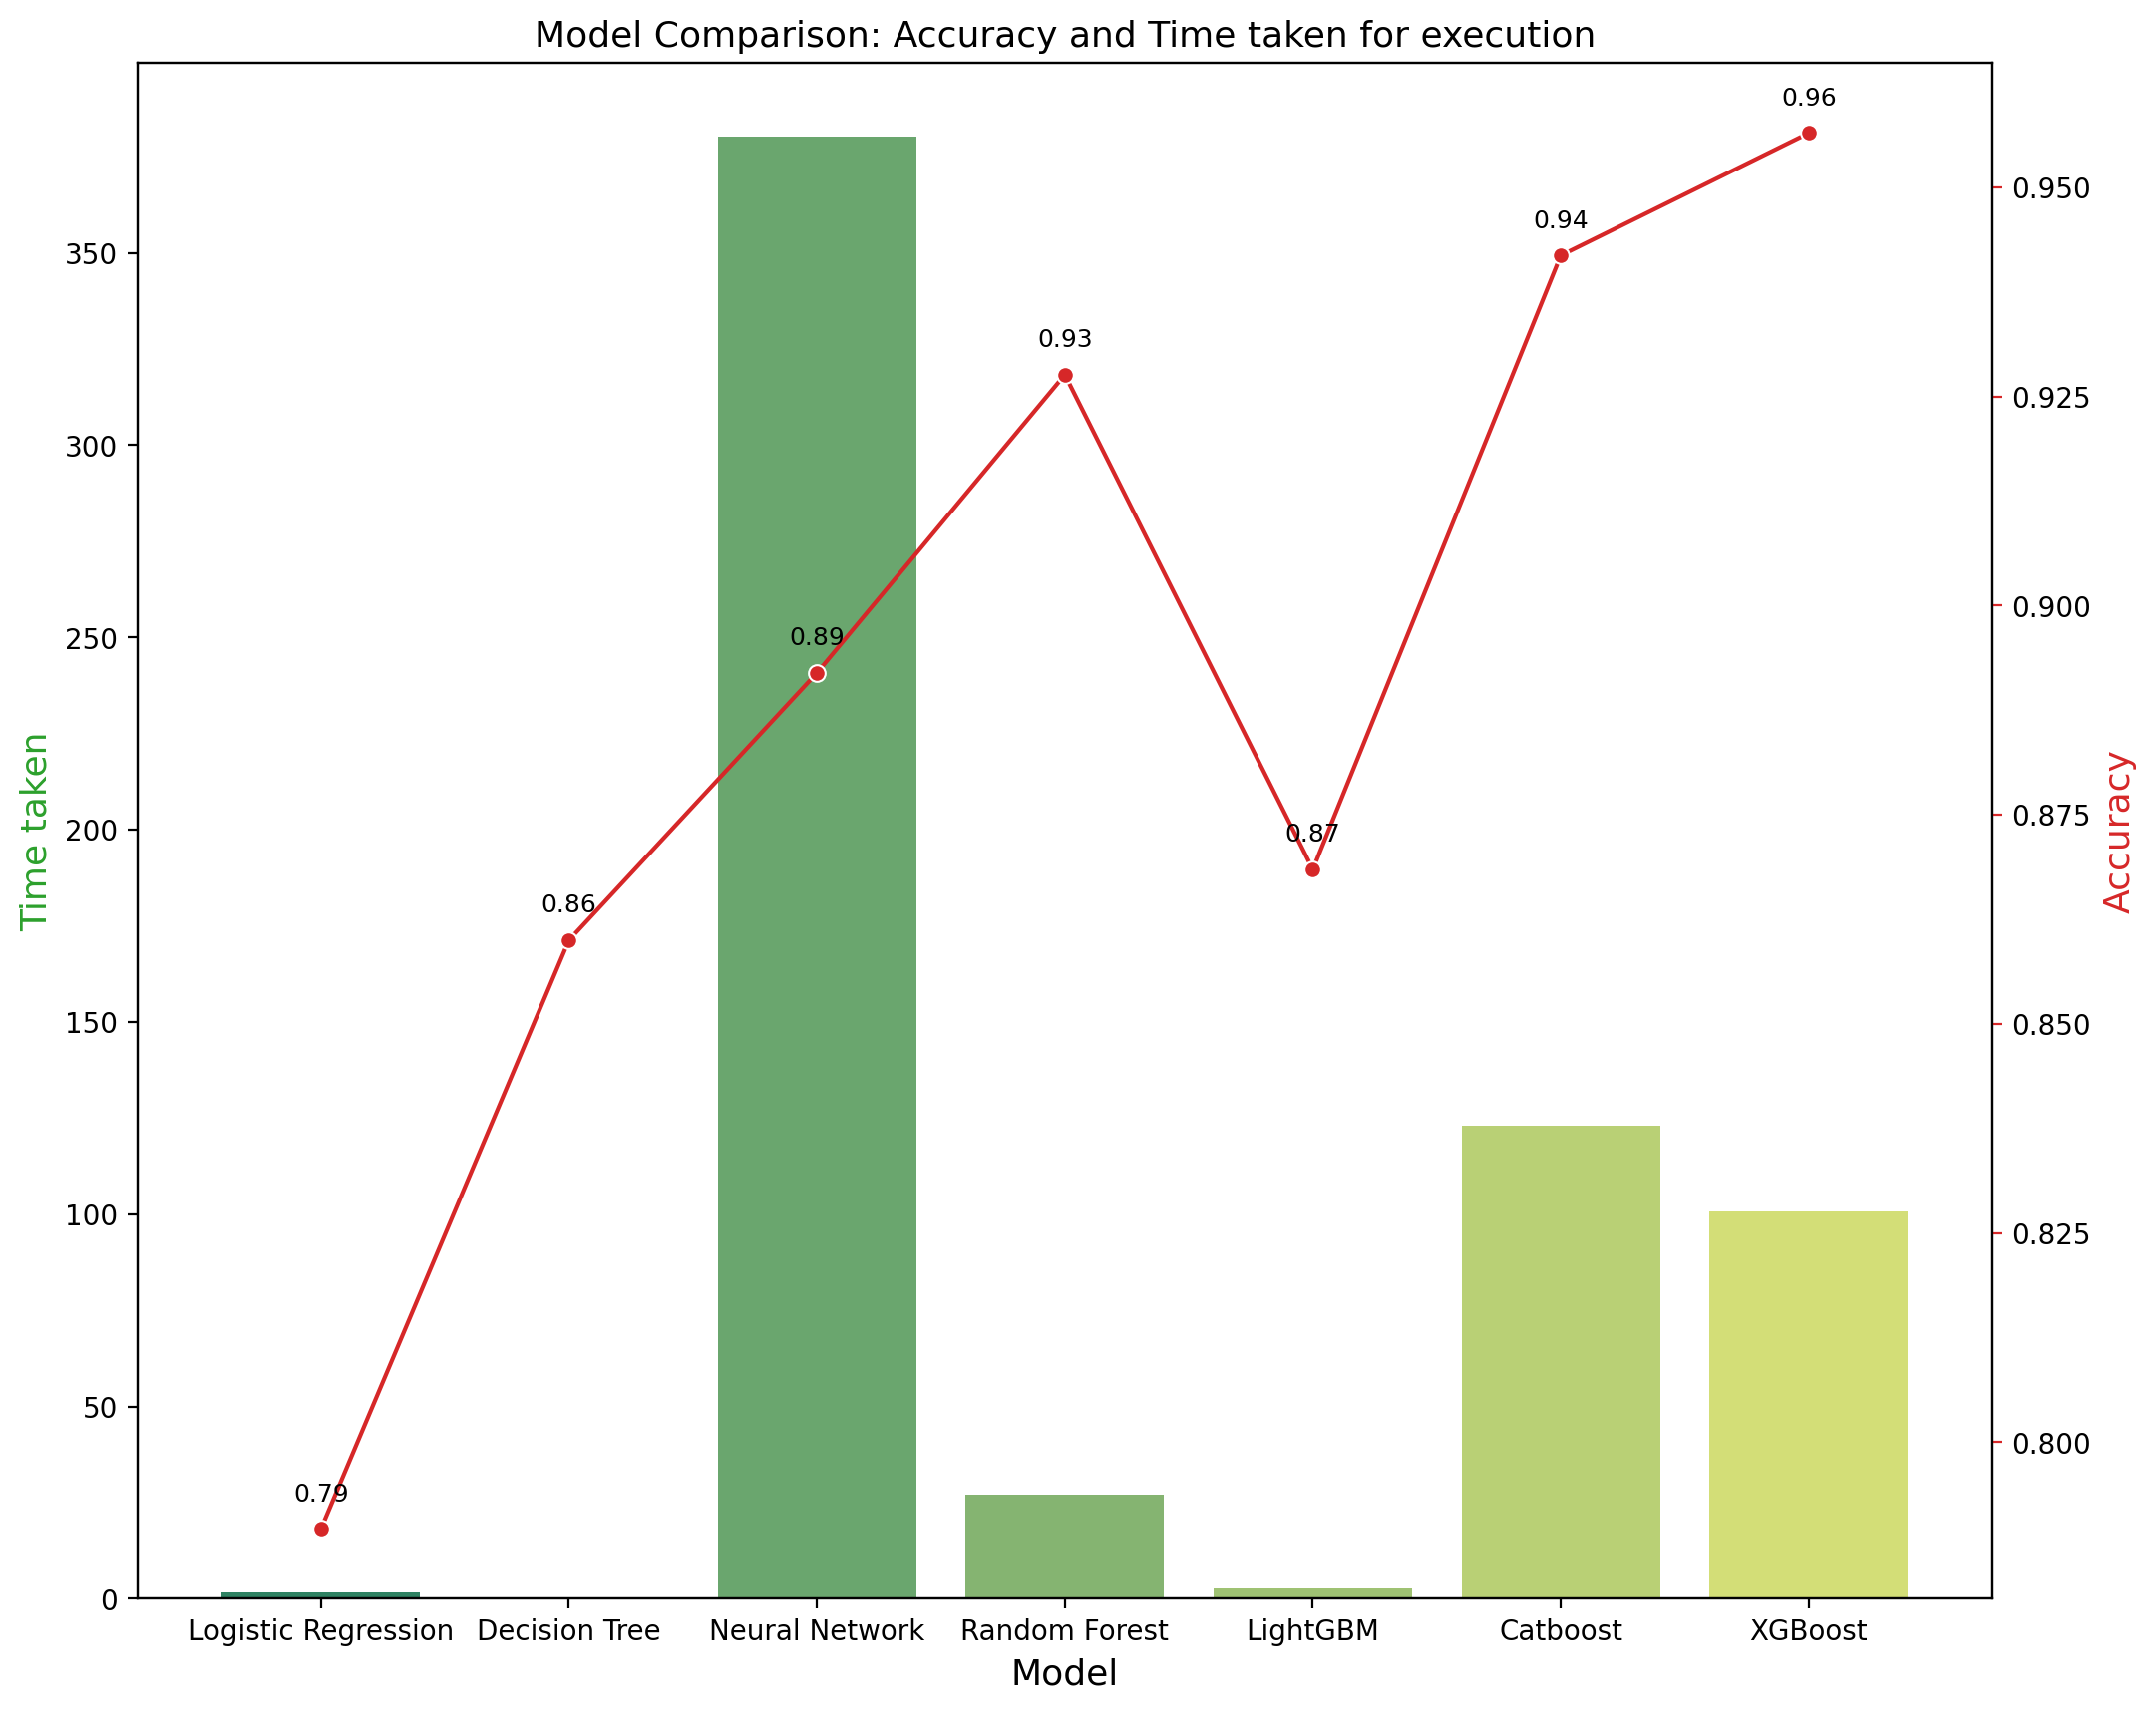

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10), dpi=200)
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data=data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data=data, sort=False, color=color, marker='o')  # Add marker for data points
ax2.tick_params(axis='y', color=color)

# Display accuracy scores alongside the line plot
for i, txt in enumerate(accuracy_scores):
    ax2.annotate(f'{txt:.2f}', (data['Model'][i], accuracy_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.show()

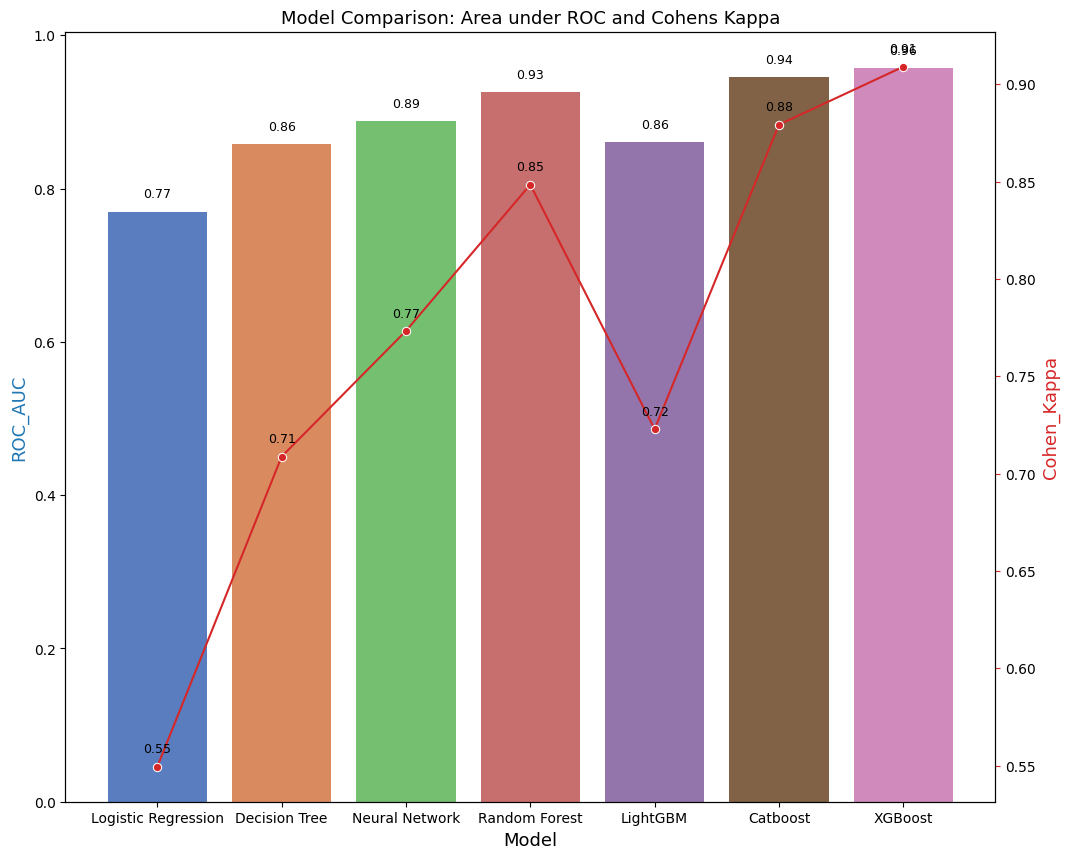

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data=data, palette='muted')

# Display ROC_AUC scores on the bar plot
for i, txt in enumerate(roc_auc_scores):
    ax4.annotate(f'{txt:.2f}', (data['Model'][i], roc_auc_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data=data, sort=False, color=color, marker='o')  # Add marker for data points

# Display Cohen_Kappa scores alongside the line plot
for i, txt in enumerate(coh_kap_scores):
    ax4.annotate(f'{txt:.2f}', (data['Model'][i], coh_kap_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

ax4.tick_params(axis='y', color=color)
plt.show()


We can observe that XGBoost, CatBoost and Random Forest performed better compared to other models. However, if speed is an important thing to consider, we can stick with Random Forest instead of XGBoost or CatBoost.